### Antoine EDY
# Natural Language Processing (COMM061) - Coursework

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import nltk
from torch.utils.tensorboard import SummaryWriter

In [2]:
dataset = load_dataset("surrey-nlp/PLOD-CW")

In [3]:
TEXT2ID = {
    "B-O": 0,
    "B-AC": 1,
    "PAD": 2,
    "B-LF": 3,
    "I-LF": 4,
}
ID2TEXT = {v: k for k, v in TEXT2ID.items()}

print(f"TEXT2ID: {TEXT2ID}\nID2TEXT: {ID2TEXT}\n")

def preprocess(df):
    df = df.drop(columns=['pos_tags'])
    df = df.rename(columns={"ner_tags": "labels"})
    df["ids"] = df["labels"].apply(lambda x: [TEXT2ID[i] for i in x])
    df["sentences"] = df["tokens"].apply(lambda x: " ".join(x))

    return df


train_dataset = preprocess(pd.DataFrame(dataset['train']))
test_dataset = preprocess(pd.DataFrame(dataset['test']))
val_dataset = preprocess(pd.DataFrame(dataset['validation']))

train_dataset.info()


# Here the exploration to add at the end of the work.

TEXT2ID: {'B-O': 0, 'B-AC': 1, 'PAD': 2, 'B-LF': 3, 'I-LF': 4}
ID2TEXT: {0: 'B-O', 1: 'B-AC', 2: 'PAD', 3: 'B-LF', 4: 'I-LF'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tokens     1072 non-null   object
 1   labels     1072 non-null   object
 2   ids        1072 non-null   object
 3   sentences  1072 non-null   object
dtypes: object(4)
memory usage: 33.6+ KB


In [4]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[For, this, purpose, the, Gothenburg, Young, P...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",For this purpose the Gothenburg Young Persons ...
1,"[The, following, physiological, traits, were, ...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",The following physiological traits were measur...
2,"[Minor, H, antigen, alloimmune, responses, rea...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",Minor H antigen alloimmune responses readily o...
3,"[EPI, =, Echo, planar, imaging, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",EPI = Echo planar imaging .
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Furthermore , eNOS - derived NO S - nitrosylat..."


In [5]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

1072
126
153


In [6]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[For, this, purpose, the, Gothenburg, Young, P...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",For this purpose the Gothenburg Young Persons ...
1,"[The, following, physiological, traits, were, ...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",The following physiological traits were measur...
2,"[Minor, H, antigen, alloimmune, responses, rea...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",Minor H antigen alloimmune responses readily o...
3,"[EPI, =, Echo, planar, imaging, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",EPI = Echo planar imaging .
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Furthermore , eNOS - derived NO S - nitrosylat..."


In [7]:
from torchtext.data import Field, Dataset, Example

text_field = Field(sequential=True, tokenize=lambda x:x, include_lengths=True) # Default behaviour is to tokenize by splitting
label_field = Field(sequential=True, tokenize=lambda x:x, is_target=True)

fields = {
    'sentences': ('text', text_field),
    'ids': ('label', label_field)
}

def read_data(df):
    examples = []
    fields = {'sentence_labels': ('labels', label_field),
              'sentence_tokens': ('text', text_field)}
    
    for i in range(len(df)):
        tokens = df['tokens'][i]
        labels = df['labels'][i]
        
        e = Example.fromdict({"sentence_labels": labels, "sentence_tokens": tokens},
                             fields=fields)
        examples.append(e)
    
    return Dataset(examples, fields=[('labels', label_field), ('text', text_field)])


train_data = read_data(train_dataset)
val_data = read_data(val_dataset)
test_data = read_data(test_dataset)

print(train_data.fields)
print(train_data[0].text)
print(train_data[0].labels)

print("Train:", len(train_data))
print("Dev:", len(val_data))
print("Test:", len(test_data))

{'labels': <torchtext.data.field.Field object at 0x1079d3400>, 'text': <torchtext.data.field.Field object at 0x16c8f28f0>}
['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'was', 'developed', '.']
['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O']
Train: 1072
Dev: 126
Test: 153


In [8]:
VOCAB_SIZE = 20000

text_field.build_vocab(train_data, max_size=VOCAB_SIZE)
label_field.build_vocab(train_data)

In [9]:
from torchtext.data import BucketIterator

BATCH_SIZE = 32
train_iter = BucketIterator(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, 
                            sort_key=lambda x: len(x.text), sort_within_batch=True)
val_iter = BucketIterator(dataset=val_data, batch_size=BATCH_SIZE, 
                          sort_key=lambda x: len(x.text), sort_within_batch=True)
test_iter = BucketIterator(dataset=test_data, batch_size=BATCH_SIZE, 
                           sort_key=lambda x: len(x.text), sort_within_batch=True)

In [10]:
import random
import os
import numpy as np

emb = 'word2vec'

if emb == 'fasttext':

    EMBEDDING_PATH = "/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code/data/cc.en.300.vec"

    def load_embeddings(path):
        """ Load the FastText embeddings from the embedding file. """
        print("Loading pre-trained embeddings")
        
        embeddings = {}
        with open(path) as i:
            for line in i:
                if len(line) > 2: 
                    line = line.strip().split()
                    word = line[0]
                    embedding = np.array(line[1:])
                    embeddings[word] = embedding
        
        return embeddings
        

    def initialize_embeddings(embeddings, vocabulary):
        """ Use the pre-trained embeddings to initialize an embedding matrix. """
        print("Initializing embedding matrix")
        embedding_size = len(embeddings["."])
        embedding_matrix = np.zeros((len(vocabulary), embedding_size), dtype=np.float32)
                                    
        for idx, word in enumerate(vocabulary.itos): 
            if word in embeddings:
                embedding_matrix[idx,:] = embeddings[word]
                
        return embedding_matrix

    embeddings = load_embeddings(EMBEDDING_PATH)
    embedding_matrix = initialize_embeddings(embeddings, text_field.vocab)
    embedding_matrix = torch.from_numpy(embedding_matrix)
    print(embedding_matrix.shape)

if emb == 'word2vec':
    import gensim
    model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)
    em = []
    for word in text_field.vocab.itos:
        if word in model:
            em.append(model.get_vector(word))
        else:
            em.append(np.zeros(300))
    em = np.array(em)
    embedding_matrix = torch.tensor(em, dtype=torch.float32)
    print(embedding_matrix.shape)

torch.Size([9135, 300])


In [11]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()
        
        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=1)
        
        # 3. Optional dropout layer
        self.dropout_layer = nn.Dropout(p=0.5)

        # 4. Dense Layer
        self.hidden2tag = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text, batch_lengths):

        embeddings = self.embeddings(batch_text)
        
        packed_seqs = pack_padded_sequence(embeddings, batch_lengths)
        lstm_output, _ = self.lstm(packed_seqs)
        lstm_output, _ = pad_packed_sequence(lstm_output)
        lstm_output = self.dropout_layer(lstm_output)
        
        logits = self.hidden2tag(lstm_output)
        return logits

In [12]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, classification_report

def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 1:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES}: {label_field.vocab.itos}")

def train(model, train_iter, dev_iter, batch_size, max_epochs, num_batches, patience, output_path):
    writer = SummaryWriter()
    # add weight to indexes 3, 4, 5
    w = [0, 0, 0.0443, 0.6259, 1.0000, 0.4525]
    class_weights = torch.tensor(w).to(device)
    criterion = nn.CrossEntropyLoss(weight = class_weights, ignore_index=1)  # we mask the <pad> labels
    optimizer = optim.Adam(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):
            optimizer.zero_grad()
            
            text_length, cur_batch_size = batch.text[0].shape
            
            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size*text_length)
            
            loss = criterion(pred, gold)
            
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)
            
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        train_scores = precision_recall_fscore_support(correct, predictions, average="micro")
        train_f_score_history.append(train_scores[2])
            
        print("Total training loss:", total_loss)
        print("Training performance:", train_scores)

        #tensorboard
        writer.add_scalar('train/loss', total_loss, epoch)
        writer.add_scalar('train/precision', train_scores[2], epoch)

        
        total_loss = 0
        predictions, correct = [], []
        for batch in dev_iter:

            text_length, cur_batch_size = batch.text[0].shape

            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size * text_length)
            loss = criterion(pred, gold)
            total_loss += loss.item()

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        dev_scores = precision_recall_fscore_support(correct, predictions, average="micro")
            
        print("Total development loss:", total_loss)
        print("Development performance:", dev_scores)

        writer.add_scalar('val/loss', total_loss, epoch)
        writer.add_scalar('val/precision', dev_scores[2], epoch)

        labels = label_field.vocab.itos[2:]
        labels = sorted(labels, key=lambda x: x.split("-")[-1])
        label_idxs = [label_field.vocab.stoi[l] for l in labels]

        cr = classification_report(correct, predictions, labels = label_idxs, target_names=labels, output_dict=True)

        out = {}
        for key in cr.keys():
            if key == 'accuracy':
                out[key] = cr[key]
            else:
                for new_k in ['precision', 'recall', 'f1-score']:
                    out[key+'_'+new_k] = cr[key][new_k]
        
        for (key, value) in out.items():
            writer.add_scalar(f'test/{key}', value, epoch)
        
        dev_f = dev_scores[2]

        dev_f = out['macro avg_f1-score']

        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0
            
        if no_improvement > patience:
            print("Macro average F1-score does not improve anymore. Stop training.")
            dev_f_score_history.append(dev_f)
            break
            
        dev_f_score_history.append(dev_f)
        
    return train_f_score_history, dev_f_score_history

Number of classes: 6: ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


In [13]:
def test(model, test_iter, batch_size, labels, target_names): 
    
    total_loss = 0
    predictions, correct = [], []
    for batch in test_iter:

        text_length, cur_batch_size = batch.text[0].shape

        pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
        gold = batch.labels.to(device).view(cur_batch_size * text_length)

        _, pred_indices = torch.max(pred, 1)
        predicted_labels = list(pred_indices.cpu().numpy())
        correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())

        predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, correct_labels)

        predictions += predicted_labels
        correct += correct_labels
    
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))

In [14]:
import math

EMBEDDING_DIM = 300 #fasttext & word2vec
# EMBEDDING_DIM = 768 #bert
HIDDEN_DIM = 256
NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES} : {label_field.vocab.itos}")
MAX_EPOCHS = 70
PATIENCE = 50
OUTPUT_PATH = "model_saves/bilstmtagger"
num_batches = math.ceil(len(train_data) / BATCH_SIZE)

tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES, embeddings=embedding_matrix)  # embeddings
# tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES)  # no embeddings

train_f, dev_f = train(tagger.to(device), train_iter, val_iter, BATCH_SIZE, MAX_EPOCHS, 
                       num_batches, PATIENCE, OUTPUT_PATH)

Number of classes: 6 : ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


Epoch 0: 100%|██████████| 34/34 [00:05<00:00,  6.39it/s]


Total training loss: 44.59322738647461
Training performance: (0.2771, 0.2771, 0.2771, None)
Total development loss: 4.505491495132446
Development performance: (0.4606, 0.4606, 0.4606, None)
Saving model.


Epoch 1: 100%|██████████| 34/34 [00:05<00:00,  6.51it/s]


Total training loss: 27.964872419834137
Training performance: (0.5128, 0.5128, 0.5128, None)
Total development loss: 3.4446346759796143
Development performance: (0.5364, 0.5364, 0.5364, None)
Saving model.


Epoch 2: 100%|██████████| 34/34 [00:04<00:00,  6.88it/s]


Total training loss: 22.420595973730087
Training performance: (0.6017, 0.6017, 0.6017, None)
Total development loss: 3.2356045842170715
Development performance: (0.5456, 0.5456, 0.5456, None)
Saving model.


Epoch 3: 100%|██████████| 34/34 [00:05<00:00,  6.78it/s]


Total training loss: 19.454075038433075
Training performance: (0.64565, 0.64565, 0.64565, None)
Total development loss: 3.0161866545677185
Development performance: (0.6566, 0.6566, 0.6566, None)
Saving model.


Epoch 4: 100%|██████████| 34/34 [00:05<00:00,  6.71it/s]


Total training loss: 17.526302456855774
Training performance: (0.6853, 0.6853, 0.6853, None)
Total development loss: 3.064927399158478
Development performance: (0.57, 0.57, 0.57, None)


Epoch 5: 100%|██████████| 34/34 [00:05<00:00,  6.69it/s]


Total training loss: 16.372957080602646
Training performance: (0.693575, 0.693575, 0.693575, None)
Total development loss: 2.793994128704071
Development performance: (0.6724, 0.6724, 0.6724, None)
Saving model.


Epoch 6: 100%|██████████| 34/34 [00:05<00:00,  6.09it/s]


Total training loss: 15.401475489139557
Training performance: (0.7139, 0.7139, 0.7139, None)
Total development loss: 2.790491461753845
Development performance: (0.7092, 0.7092, 0.7092, None)
Saving model.


Epoch 7: 100%|██████████| 34/34 [00:04<00:00,  6.91it/s]


Total training loss: 13.985391303896904
Training performance: (0.749425, 0.749425, 0.749425, None)
Total development loss: 2.685593843460083
Development performance: (0.7108, 0.7108, 0.7108, None)
Saving model.


Epoch 8: 100%|██████████| 34/34 [00:04<00:00,  6.83it/s]


Total training loss: 13.262774139642715
Training performance: (0.74815, 0.74815, 0.74815, None)
Total development loss: 2.650449812412262
Development performance: (0.7126, 0.7126, 0.7126, None)
Saving model.


Epoch 9: 100%|██████████| 34/34 [00:04<00:00,  7.16it/s]


Total training loss: 11.854285061359406
Training performance: (0.771625, 0.771625, 0.771625, None)
Total development loss: 2.6897128224372864
Development performance: (0.7454, 0.7454, 0.7454, None)
Saving model.


Epoch 10: 100%|██████████| 34/34 [00:04<00:00,  6.93it/s]


Total training loss: 11.386688724160194
Training performance: (0.78325, 0.78325, 0.78325, None)
Total development loss: 2.7085142731666565
Development performance: (0.6498, 0.6498, 0.6498, None)


Epoch 11: 100%|██████████| 34/34 [00:04<00:00,  6.97it/s]


Total training loss: 10.280376374721527
Training performance: (0.7981, 0.7981, 0.7981, None)
Total development loss: 2.801142990589142
Development performance: (0.7198, 0.7198, 0.7198, None)


Epoch 12: 100%|██████████| 34/34 [00:04<00:00,  6.94it/s]


Total training loss: 9.66869705915451
Training performance: (0.805775, 0.805775, 0.805775, None)
Total development loss: 2.8667373061180115
Development performance: (0.6942, 0.6942, 0.6942, None)


Epoch 13: 100%|██████████| 34/34 [00:04<00:00,  6.84it/s]


Total training loss: 8.968911215662956
Training performance: (0.81, 0.81, 0.81, None)
Total development loss: 3.0652021169662476
Development performance: (0.7938, 0.7938, 0.7938, None)
Saving model.


Epoch 14: 100%|██████████| 34/34 [00:04<00:00,  7.52it/s]


Total training loss: 7.85205078125
Training performance: (0.839025, 0.839025, 0.839025, None)
Total development loss: 2.9323302507400513
Development performance: (0.7592, 0.7592, 0.7592, None)


Epoch 15: 100%|██████████| 34/34 [00:04<00:00,  7.04it/s]


Total training loss: 6.921356663107872
Training performance: (0.851525, 0.851525, 0.851525, None)
Total development loss: 3.322786808013916
Development performance: (0.8098, 0.8098, 0.8098, None)
Saving model.


Epoch 16: 100%|██████████| 34/34 [00:05<00:00,  6.70it/s]


Total training loss: 6.2039294093847275
Training performance: (0.864825, 0.864825, 0.864825, None)
Total development loss: 2.9697201251983643
Development performance: (0.7278, 0.7278, 0.7278, None)


Epoch 17: 100%|██████████| 34/34 [00:04<00:00,  7.37it/s]


Total training loss: 5.751390531659126
Training performance: (0.86755, 0.86755, 0.86755, None)
Total development loss: 3.8274325132369995
Development performance: (0.8252, 0.8252, 0.8252, None)
Saving model.


Epoch 18: 100%|██████████| 34/34 [00:04<00:00,  6.98it/s]


Total training loss: 5.4444844871759415
Training performance: (0.882075, 0.882075, 0.882075, None)
Total development loss: 3.2915780544281006
Development performance: (0.7682, 0.7682, 0.7682, None)


Epoch 19: 100%|██████████| 34/34 [00:04<00:00,  6.97it/s]


Total training loss: 4.66986982524395
Training performance: (0.893475, 0.893475, 0.893475, None)
Total development loss: 4.1822381019592285
Development performance: (0.8312, 0.8312, 0.8312, None)


Epoch 20: 100%|██████████| 34/34 [00:05<00:00,  6.77it/s]


Total training loss: 4.663622632622719
Training performance: (0.8983, 0.8983, 0.8983, None)
Total development loss: 3.5068647861480713
Development performance: (0.7656, 0.7656, 0.7656, None)


Epoch 21: 100%|██████████| 34/34 [00:04<00:00,  6.94it/s]


Total training loss: 4.244549207389355
Training performance: (0.907125, 0.907125, 0.907125, None)
Total development loss: 3.198092520236969
Development performance: (0.7366, 0.7366, 0.7366, None)


Epoch 22: 100%|██████████| 34/34 [00:04<00:00,  7.12it/s]


Total training loss: 3.86333991214633
Training performance: (0.90425, 0.90425, 0.90425, None)
Total development loss: 4.365160882472992
Development performance: (0.8142, 0.8142, 0.8142, None)


Epoch 23: 100%|██████████| 34/34 [00:04<00:00,  7.23it/s]


Total training loss: 3.259633332490921
Training performance: (0.925525, 0.925525, 0.925525, None)
Total development loss: 4.5445809960365295
Development performance: (0.8166, 0.8166, 0.8166, None)


Epoch 24: 100%|██████████| 34/34 [00:04<00:00,  7.04it/s]


Total training loss: 2.9187543280422688
Training performance: (0.93105, 0.93105, 0.93105, None)
Total development loss: 4.67091429233551
Development performance: (0.8258, 0.8258, 0.8258, None)


Epoch 25: 100%|██████████| 34/34 [00:04<00:00,  6.94it/s]


Total training loss: 2.7961005866527557
Training performance: (0.933575, 0.933575, 0.933575, None)
Total development loss: 4.906975865364075
Development performance: (0.8186, 0.8186, 0.8186, None)


Epoch 26: 100%|██████████| 34/34 [00:05<00:00,  6.73it/s]


Total training loss: 2.538127116858959
Training performance: (0.941275, 0.941275, 0.941275, None)
Total development loss: 4.803732335567474
Development performance: (0.8286, 0.8286, 0.8286, None)


Epoch 27: 100%|██████████| 34/34 [00:04<00:00,  6.98it/s]


Total training loss: 2.346688147634268
Training performance: (0.94345, 0.94345, 0.94345, None)
Total development loss: 5.343642354011536
Development performance: (0.8326, 0.8326, 0.8326, None)


Epoch 28: 100%|██████████| 34/34 [00:04<00:00,  6.93it/s]


Total training loss: 2.0514861661940813
Training performance: (0.950825, 0.950825, 0.950825, None)
Total development loss: 6.603135347366333
Development performance: (0.8608, 0.8608, 0.8608, None)
Saving model.


Epoch 29: 100%|██████████| 34/34 [00:04<00:00,  7.01it/s]


Total training loss: 1.6921414360404015
Training performance: (0.95955, 0.95955, 0.95955, None)
Total development loss: 5.859326362609863
Development performance: (0.8364, 0.8364, 0.8364, None)


Epoch 30: 100%|██████████| 34/34 [00:06<00:00,  5.49it/s]


Total training loss: 1.5815058257430792
Training performance: (0.96205, 0.96205, 0.96205, None)
Total development loss: 6.30253541469574
Development performance: (0.8502, 0.8502, 0.8502, None)


Epoch 31: 100%|██████████| 34/34 [00:05<00:00,  5.78it/s]


Total training loss: 1.6246141158044338
Training performance: (0.961225, 0.961225, 0.961225, None)
Total development loss: 6.49357807636261
Development performance: (0.8542, 0.8542, 0.8542, None)


Epoch 32: 100%|██████████| 34/34 [00:05<00:00,  6.16it/s]


Total training loss: 1.3002379313111305
Training performance: (0.967225, 0.967225, 0.967225, None)
Total development loss: 6.604887008666992
Development performance: (0.838, 0.838, 0.838, None)


Epoch 33: 100%|██████████| 34/34 [00:05<00:00,  6.48it/s]


Total training loss: 1.1914063543081284
Training performance: (0.9716, 0.9716, 0.9716, None)
Total development loss: 6.837285041809082
Development performance: (0.8488, 0.8488, 0.8488, None)


Epoch 34: 100%|██████████| 34/34 [00:04<00:00,  7.29it/s]


Total training loss: 1.0202168133109808
Training performance: (0.975025, 0.975025, 0.975025, None)
Total development loss: 7.947956681251526
Development performance: (0.8632, 0.8632, 0.8632, None)


Epoch 35: 100%|██████████| 34/34 [00:05<00:00,  6.50it/s]


Total training loss: 1.215178963728249
Training performance: (0.9704, 0.9704, 0.9704, None)
Total development loss: 6.410141229629517
Development performance: (0.8204, 0.8204, 0.8204, None)


Epoch 36: 100%|██████████| 34/34 [00:05<00:00,  6.73it/s]


Total training loss: 1.2054306715726852
Training performance: (0.969475, 0.969475, 0.969475, None)
Total development loss: 7.663728713989258
Development performance: (0.8614, 0.8614, 0.8614, None)


Epoch 37: 100%|██████████| 34/34 [00:04<00:00,  7.15it/s]


Total training loss: 0.8999510426074266
Training performance: (0.9793, 0.9793, 0.9793, None)
Total development loss: 6.934944272041321
Development performance: (0.839, 0.839, 0.839, None)


Epoch 38: 100%|██████████| 34/34 [00:04<00:00,  7.20it/s]


Total training loss: 1.1517537897452712
Training performance: (0.9716, 0.9716, 0.9716, None)
Total development loss: 7.188336253166199
Development performance: (0.8484, 0.8484, 0.8484, None)


Epoch 39: 100%|██████████| 34/34 [00:05<00:00,  6.26it/s]


Total training loss: 0.9330552788451314
Training performance: (0.977525, 0.977525, 0.977525, None)
Total development loss: 7.920595765113831
Development performance: (0.852, 0.852, 0.852, None)


Epoch 40: 100%|██████████| 34/34 [00:05<00:00,  5.69it/s]


Total training loss: 0.7311584446579218
Training performance: (0.9833, 0.9833, 0.9833, None)
Total development loss: 8.402252316474915
Development performance: (0.8596, 0.8596, 0.8596, None)


Epoch 41: 100%|██████████| 34/34 [00:05<00:00,  6.76it/s]


Total training loss: 0.7275997502729297
Training performance: (0.98175, 0.98175, 0.98175, None)
Total development loss: 8.709981083869934
Development performance: (0.8678, 0.8678, 0.8678, None)


Epoch 42: 100%|██████████| 34/34 [00:04<00:00,  6.89it/s]


Total training loss: 0.7094020927324891
Training performance: (0.983275, 0.983275, 0.983275, None)
Total development loss: 7.6988362073898315
Development performance: (0.8554, 0.8554, 0.8554, None)


Epoch 43: 100%|██████████| 34/34 [00:04<00:00,  6.95it/s]


Total training loss: 0.6860375297255814
Training performance: (0.982925, 0.982925, 0.982925, None)
Total development loss: 8.743533253669739
Development performance: (0.8664, 0.8664, 0.8664, None)


Epoch 44: 100%|██████████| 34/34 [00:04<00:00,  7.23it/s]


Total training loss: 0.6276568560861051
Training performance: (0.9843, 0.9843, 0.9843, None)
Total development loss: 8.442186832427979
Development performance: (0.8548, 0.8548, 0.8548, None)


Epoch 45: 100%|██████████| 34/34 [00:04<00:00,  6.98it/s]


Total training loss: 0.699700441211462
Training performance: (0.983075, 0.983075, 0.983075, None)
Total development loss: 8.829813599586487
Development performance: (0.87, 0.87, 0.87, None)
Saving model.


Epoch 46: 100%|██████████| 34/34 [00:04<00:00,  7.17it/s]


Total training loss: 0.5029060295782983
Training performance: (0.9884, 0.9884, 0.9884, None)
Total development loss: 8.908054232597351
Development performance: (0.8666, 0.8666, 0.8666, None)


Epoch 47: 100%|██████████| 34/34 [00:04<00:00,  6.80it/s]


Total training loss: 0.4178056404925883
Training performance: (0.99045, 0.99045, 0.99045, None)
Total development loss: 9.201489210128784
Development performance: (0.8662, 0.8662, 0.8662, None)


Epoch 48: 100%|██████████| 34/34 [00:04<00:00,  7.54it/s]


Total training loss: 0.3716429134365171
Training performance: (0.9923, 0.9923, 0.9923, None)
Total development loss: 10.271423101425171
Development performance: (0.8668, 0.8668, 0.8668, None)


Epoch 49: 100%|██████████| 34/34 [00:04<00:00,  7.16it/s]


Total training loss: 0.2933853408321738
Training performance: (0.993725, 0.993725, 0.993725, None)
Total development loss: 9.631053924560547
Development performance: (0.8604, 0.8604, 0.8604, None)


Epoch 50: 100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Total training loss: 0.3220007955096662
Training performance: (0.993525, 0.993525, 0.993525, None)
Total development loss: 10.143798828125
Development performance: (0.8594, 0.8594, 0.8594, None)


Epoch 51: 100%|██████████| 34/34 [00:04<00:00,  7.08it/s]


Total training loss: 0.27900317194871604
Training performance: (0.9939, 0.9939, 0.9939, None)
Total development loss: 10.162903547286987
Development performance: (0.8674, 0.8674, 0.8674, None)


Epoch 52: 100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Total training loss: 0.2564648377010599
Training performance: (0.994575, 0.994575, 0.994575, None)
Total development loss: 10.001692056655884
Development performance: (0.8626, 0.8626, 0.8626, None)


Epoch 53: 100%|██████████| 34/34 [00:04<00:00,  7.23it/s]


Total training loss: 0.30159151554107666
Training performance: (0.993575, 0.993575, 0.993575, None)
Total development loss: 10.287713766098022
Development performance: (0.8574, 0.8574, 0.8574, None)


Epoch 54: 100%|██████████| 34/34 [00:04<00:00,  7.61it/s]


Total training loss: 0.25975288450717926
Training performance: (0.994425, 0.994425, 0.994425, None)
Total development loss: 10.56296706199646
Development performance: (0.8534, 0.8534, 0.8534, None)


Epoch 55: 100%|██████████| 34/34 [00:04<00:00,  6.95it/s]


Total training loss: 0.27643740247003734
Training performance: (0.993625, 0.993625, 0.993625, None)
Total development loss: 10.939492225646973
Development performance: (0.8658, 0.8658, 0.8658, None)


Epoch 56: 100%|██████████| 34/34 [00:04<00:00,  7.01it/s]


Total training loss: 0.322461519157514
Training performance: (0.99245, 0.99245, 0.99245, None)
Total development loss: 10.018348693847656
Development performance: (0.8624, 0.8624, 0.8624, None)


Epoch 57: 100%|██████████| 34/34 [00:04<00:00,  7.29it/s]


Total training loss: 0.2767133249435574
Training performance: (0.993825, 0.993825, 0.993825, None)
Total development loss: 10.693390369415283
Development performance: (0.8594, 0.8594, 0.8594, None)


Epoch 58: 100%|██████████| 34/34 [00:04<00:00,  7.17it/s]


Total training loss: 0.3548900946043432
Training performance: (0.9913, 0.9913, 0.9913, None)
Total development loss: 9.10917043685913
Development performance: (0.8512, 0.8512, 0.8512, None)


Epoch 59: 100%|██████████| 34/34 [00:04<00:00,  7.16it/s]


Total training loss: 2.45302143599838
Training performance: (0.950375, 0.950375, 0.950375, None)
Total development loss: 6.74078369140625
Development performance: (0.8342, 0.8342, 0.8342, None)


Epoch 60: 100%|██████████| 34/34 [00:04<00:00,  7.70it/s]


Total training loss: 2.3151553831994534
Training performance: (0.9457, 0.9457, 0.9457, None)
Total development loss: 5.88471519947052
Development performance: (0.8258, 0.8258, 0.8258, None)


Epoch 61: 100%|██████████| 34/34 [00:04<00:00,  7.58it/s]


Total training loss: 1.352178399451077
Training performance: (0.96535, 0.96535, 0.96535, None)
Total development loss: 6.581879138946533
Development performance: (0.844, 0.844, 0.844, None)


Epoch 62: 100%|██████████| 34/34 [00:04<00:00,  7.84it/s]


Total training loss: 0.665676839184016
Training performance: (0.98215, 0.98215, 0.98215, None)
Total development loss: 8.50543761253357
Development performance: (0.8654, 0.8654, 0.8654, None)


Epoch 63: 100%|██████████| 34/34 [00:04<00:00,  6.92it/s]


Total training loss: 0.4652990438044071
Training performance: (0.98955, 0.98955, 0.98955, None)
Total development loss: 8.449998378753662
Development performance: (0.8626, 0.8626, 0.8626, None)


Epoch 64: 100%|██████████| 34/34 [00:04<00:00,  7.04it/s]


Total training loss: 0.34579166769981384
Training performance: (0.992575, 0.992575, 0.992575, None)
Total development loss: 8.513863205909729
Development performance: (0.848, 0.848, 0.848, None)


Epoch 65: 100%|██████████| 34/34 [00:04<00:00,  7.02it/s]


Total training loss: 0.25667517026886344
Training performance: (0.9943, 0.9943, 0.9943, None)
Total development loss: 10.274835109710693
Development performance: (0.8708, 0.8708, 0.8708, None)


Epoch 66: 100%|██████████| 34/34 [00:04<00:00,  6.88it/s]


Total training loss: 0.1909655297640711
Training performance: (0.996325, 0.996325, 0.996325, None)
Total development loss: 11.088401317596436
Development performance: (0.8718, 0.8718, 0.8718, None)


Epoch 67: 100%|██████████| 34/34 [00:04<00:00,  7.02it/s]


Total training loss: 0.1704226634465158
Training performance: (0.9966, 0.9966, 0.9966, None)
Total development loss: 10.840176820755005
Development performance: (0.8634, 0.8634, 0.8634, None)


Epoch 68: 100%|██████████| 34/34 [00:04<00:00,  7.46it/s]


Total training loss: 0.14480598364025354
Training performance: (0.99755, 0.99755, 0.99755, None)
Total development loss: 10.97702670097351
Development performance: (0.863, 0.863, 0.863, None)


Epoch 69: 100%|██████████| 34/34 [00:04<00:00,  7.04it/s]


Total training loss: 0.11975949094630778
Training performance: (0.998275, 0.998275, 0.998275, None)
Total development loss: 11.444353818893433
Development performance: (0.8658, 0.8658, 0.8658, None)


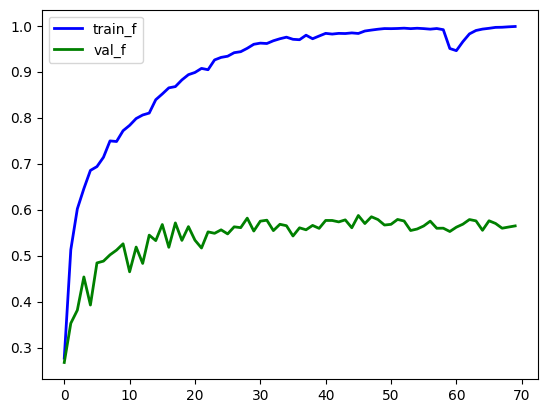

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

# Data
df = pd.DataFrame({'epochs': range(0,len(train_f)), 
                  'train_f': train_f, 
                   'val_f': dev_f})
 
# multiple line plot
plt.plot('epochs', 'train_f', data=df, color='blue', linewidth=2)
plt.plot('epochs', 'val_f', data=df, color='green', linewidth=2)
plt.legend()
plt.show()


In [16]:
%load_ext tensorboard

In [17]:
OUTPUT_PATH = "model_saves/bilstmtagger"

In [18]:
tagger = torch.load(OUTPUT_PATH)
tagger.eval()

BiLSTMTagger(
  (embeddings): Embedding(9135, 300)
  (lstm): LSTM(300, 256, bidirectional=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (hidden2tag): Linear(in_features=512, out_features=6, bias=True)
)

In [19]:
labels = label_field.vocab.itos[2:]
labels = sorted(labels, key=lambda x: x.split("-")[-1])
label_idxs = [label_field.vocab.stoi[l] for l in labels]

test(tagger, test_iter, BATCH_SIZE, labels = label_idxs, target_names = labels)

              precision    recall  f1-score   support

        B-AC       0.45      0.45      0.45       270
        I-LF       0.56      0.44      0.49       288
        B-LF       0.41      0.31      0.36       150
         B-O       0.92      0.94      0.93      4292

    accuracy                           0.86      5000
   macro avg       0.58      0.53      0.56      5000
weighted avg       0.86      0.86      0.86      5000



In [20]:
from colorama import Back, Style

def vizu(words, output, truth):
    if isinstance(output, torch.Tensor):
        output = output.squeeze().tolist()
    col = {0: Back.GREEN, 1: Back.RED, 2: Back.BLACK, 3: Back.BLUE, 4: Back.MAGENTA}
    colors1 = [col[i] for i in output]
    colors2 = [col[i] for i in truth]
    words = [word.replace("Ġ", "") for word in words]
    print(Style.RESET_ALL + "Output:")
    for i, word in enumerate(words):
        print(colors1[i] + word, end=" ")
    print(Style.RESET_ALL + "\nTruth:")
    for i, word in enumerate(words):
        print(colors2[i] + word, end=" ")